# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [1]:
%pip install pyrosm keplergl haversine pandas numpy

In [2]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time

from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [3]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd drive/MyDrive/AI_project_phase_1

/content/drive/MyDrive/AI_project_phase_1


## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [6]:
# Load the data
pasdaran_streets = pd.read_csv('pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('pasdaran_nodes.csv')

In [215]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [216]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [217]:
from IPython.display import display

map_1 = KeplerGl(height=500)

map_1.add_data(data=pasdaran_streets, name='my_data')

display(map_1)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [218]:
map_2 = KeplerGl(height=500)
map_2.add_data(data=pasdaran_nodes, name='my_data2')
display(map_2)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data2': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [233]:
import heapq
import pandas as pd

def dijkstra(graph, start, end):
    priority_queue = [(0, start)]
    distances = {node: float('infinity') for node in graph}
    distances[start] = 0
    predecessors = {node: None for node in graph}

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    current = end
    while current is not None:
        path.insert(0, current)
        current = predecessors[current]

    return path

# TODO: You should implement this from scratch and you cannot use any library (such as networkx) for finding the shortest path.
def find_shortest_path(start_node, end_node, graph):
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    ## graph is pasdaran_streets
    # slat, slon = start_node
    # elat, elon = end_node

    # start_id = graph[(graph['u_lat'] == slat) & (graph['u_lon'] == slon)]['u'].values
    # if len(start_id) == 0:
    #     start_id = graph[(graph['v_lat'] == slat) & (graph['v_lon'] == slon)]['v'].values

    # end_id = graph[(graph['u_lat'] == elat) & (graph['u_lon'] == elon)]['u'].values
    # if len(end_id) == 0:
    #     end_id = graph[(graph['v_lat'] == elat) & (graph['v_lon'] == elon)]['v'].values

    # snode = start_id[0]
    # enode = end_id[0]


    g = {}
    data = graph[['u', 'v', 'length', 'oneway']].values
    for i, row in enumerate(data):
        if row[0] not in g:
            g[row[0]] = []
        if row[1] not in g:
            g[row[1]] = []

        g[row[0]] += [(row[1], row[2])]
        # if row[3] == 'yes':
        g[row[1]] += [(row[0], row[2])]

    shortest = dijkstra(g, start_node, end_node)

    return shortest

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [144]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

random_row = pasdaran_streets.sample(n=2)
s = find_shortest_path(random_row['u'].values[0], random_row['v'].values[1], pasdaran_streets)
print(s)
# # TODO: Implement and print out a sample trip


[424058130, 424058134, 424058120, 424058123, 4695622374, 4695622381, 4683382444, 4695622378, 4695622380, 4683382443, 4695737210, 4695737204, 4695737198, 4695737196, 4695737194, 4695737195, 4695735788, 4695737199, 4695735780, 4695735771, 423816750, 4695735779]


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [145]:
#TODO: Visualize the sampled trip using kepler
df = pd.DataFrame({'id': s})

path = pasdaran_nodes[pasdaran_nodes['id'].isin(s)]

path = pd.DataFrame()
for node in s:
    selected_row = pasdaran_nodes.loc[pasdaran_nodes['id'] == node]
    path = pd.concat([path, selected_row], ignore_index=True)


path['timestep'] = range(1, len(path) + 1)

map_3 = KeplerGl(height=500)
map_3.add_data(data=path, name='my_data3')
display(map_3)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data3': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [187]:
#TODO
def visualize_a_ride(ride_speed, ride_gps_time, trip):
    idx = 0
    distance = ride_speed * ride_gps_time


    row = pasdaran_streets[pasdaran_streets['u'] == trip[0]][['u_lat', 'u_lon']]
    if len(row) == 0:
        row = pasdaran_streets[pasdaran_streets['v'] == trip[0]][['v_lat', 'v_lon']]

    pairs = [row.values[0].tolist()]

    while True:
        src = trip[idx]
        dst = trip[idx+1]
        row = pasdaran_streets[(pasdaran_streets['u'] == src) & (pasdaran_streets['v'] == dst)][['length', 'u_lat', 'u_lon', 'v_lat', 'v_lon']]
        if len(row) == 0:
            row = pasdaran_streets[(pasdaran_streets['v'] == src) & (pasdaran_streets['u'] == dst)][['length', 'v_lat', 'v_lon', 'u_lat', 'u_lon']]

        row = row.values
        street_len = row[0, 0]

        while distance <= street_len:
            # print('slatlon:', row[0, 1], row[0, 2])
            # print('dlatlon:', row[0, 3], row[0, 4])
            # print('street_len:', street_len)
            lat = row[0, 1] + (row[0, 3] - row[0, 1]) * distance / street_len
            lon = row[0, 2] + (row[0, 4] - row[0, 2]) * distance / street_len
            # print(distance, lat, lon)
            # print('\n')
            pairs.append([lat, lon])
            street_len -= distance
            distance = ride_speed * ride_gps_time

        if distance > street_len:
            distance -= street_len
        idx += 1
        if idx == len(trip)-1:
            break
    return pairs

See a sample ride, printed out.

In [188]:
#TODO
sample_ride = visualize_a_ride(10, 5, s)
sample_ride

[[35.77732849121094, 51.45542526245117],
 [35.77709586396861, 51.455113888934555],
 [35.77722638447824, 51.4546765063757],
 [35.77740052876674, 51.4540771061729],
 [35.776966801435464, 51.45393101312083],
 [35.77690227777474, 51.453555436878794],
 [35.77706010579814, 51.453036490784044],
 [35.77717430277443, 51.4526414309742],
 [35.77724368705912, 51.45240139885419],
 [35.777412474339016, 51.451817486102094],
 [35.777316999987875, 51.451150384505084],
 [35.77693449737405, 51.450981237620574],
 [35.77647017639567, 51.450777210084794],
 [35.776052412250884, 51.45059405240555],
 [35.775623257331915, 51.45040436968114],
 [35.775199990987446, 51.45021728230087],
 [35.774818959547495, 51.450048962587104],
 [35.77435355209325, 51.4498427963775],
 [35.77397192385237, 51.44967296182004],
 [35.773705051398004, 51.44929286286709],
 [35.77384075790456, 51.44885365059252],
 [35.773914590799826, 51.44861469142474],
 [35.77410113706852, 51.448010936947],
 [35.773943396909544, 51.44744720029548],
 [35

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [189]:
# #TODO: Visualize the sampled ride using kepler
columns = ['lat', 'lon']

# Create a DataFrame from the list
df = pd.DataFrame(sample_ride, columns=columns)
df['timestep'] = list(range(1, len(df) + 1))


map_4 = KeplerGl(height=500)
map_4.add_data(data=df, name='my_data4')
display(map_4)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data4': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [190]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
# TODO
def add_gps_noise_to_ride(ride, gps_noise_radius):
    # Generate random noise from a normal distribution with mean=0 and std=gps_noise_radius
    noise_lat = np.random.normal(loc=0, scale=gps_noise_radius / 111320, size = (len(ride)))  # 1 degree of latitude is approximately 111320 meters
    noise_lon = np.random.normal(loc=0, scale=gps_noise_radius/111320, size = (len(ride)))

    # Add noise to Latitude and Longitude columns
    ride['lat'] += noise_lat
    ride['lon'] += noise_lon

    return ride

gps_noise_radius = np.random.uniform(3, 8)  # Randomly select a noise radius between 3 and 8 meters
noisy_ride_df = add_gps_noise_to_ride(df.copy(), gps_noise_radius)

noisy_ride_df.head()

# Print out a sample

,lat,lon,timestep
0,35.777407,51.455455,1
1,35.777165,51.455097,2
2,35.777253,51.454660,3
3,35.777415,51.454164,4
4,35.776957,51.454012,5


### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

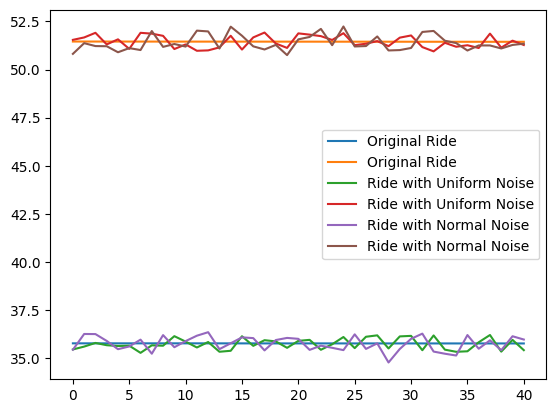

In [204]:
import matplotlib.pyplot as plt
#TODO: Experimenting with different GPS noise radiuses
# Function to add noise to rides based on a specified distribution
def add_noise_to_ride(ride, n1, n2):
    res = []
    for i in range(len(n1)):
        a = n1[i] + ride[i][0]
        b = n2[i] + ride[i][1]
        res.append([a, b])
    return res

uniform_noise1 = np.random.uniform(low=-0.5, high=0.5, size=len(sample_ride))
uniform_noise2 = np.random.uniform(low=-0.5, high=0.5, size=len(sample_ride))

normal_noise1 = np.random.normal(loc=0, scale=0.4, size=len(sample_ride))
normal_noise2 = np.random.normal(loc=0, scale=0.4, size=len(sample_ride))

ride_with_uniform_noise = add_noise_to_ride(sample_ride.copy(), uniform_noise1, uniform_noise2)
ride_with_normal_noise = add_noise_to_ride(sample_ride.copy(), normal_noise1, normal_noise2)

# Visualize rides with different noise models
plt.plot(sample_ride, label='Original Ride')
plt.plot(ride_with_uniform_noise, label='Ride with Uniform Noise')
plt.plot(ride_with_normal_noise, label='Ride with Normal Noise')
plt.legend()
plt.show()


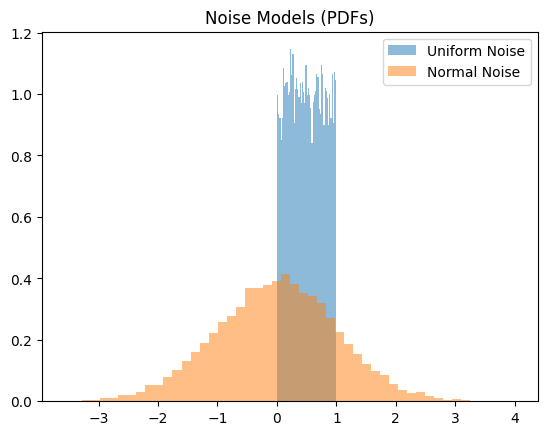

In [161]:
#TODO: Visualize the noise models using matplotlib
# Visualize noise models (PDFs)
num_samples = 10000
uniform_samples = uniform_noise_model(size=num_samples)
normal_samples = normal_noise_model(size=num_samples)

plt.hist(uniform_samples, bins=50, density=True, alpha=0.5, label='Uniform Noise')
plt.hist(normal_samples, bins=50, density=True, alpha=0.5, label='Normal Noise')
plt.legend()
plt.title('Noise Models (PDFs)')
plt.show()


In [211]:
#TODO: Visualize the noise models using kepler
columns = ['lat', 'lon']

uniform_noise1 = np.random.uniform(low=-0.0005, high=0.0005, size=len(sample_ride))
uniform_noise2 = np.random.uniform(low=-0.0005, high=0.0005, size=len(sample_ride))

normal_noise1 = np.random.normal(loc=0, scale=0.0001, size=len(sample_ride))
normal_noise2 = np.random.normal(loc=0, scale=0.0001, size=len(sample_ride))

ride_with_uniform_noise = add_noise_to_ride(sample_ride.copy(), uniform_noise1, uniform_noise2)
ride_with_normal_noise = add_noise_to_ride(sample_ride.copy(), normal_noise1, normal_noise2)


df_normal = pd.DataFrame(ride_with_normal_noise, columns=columns)
df_uniform = pd.DataFrame(ride_with_uniform_noise, columns=columns)
df_original = pd.DataFrame(sample_ride, columns=columns)

map_4 = KeplerGl(height=500)
map_4.add_data(data=df_original, name='my_data4')
map_4.add_data(data=df_normal, name='my_data5')
display(map_4)



map_5 = KeplerGl(height=500)
map_5.add_data(data=df_original, name='my_data6')
map_5.add_data(data=df_uniform, name='my_data7')
display(map_5)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data4': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data6': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

In [212]:
#TODO: Choose the best model (while you explain why you chose it)
# I chose normal because it's realy closer to reality. for example the chance of you being at distance d from your gps signal gets more when d decreases.
# also it is a good function and smooth. also I heard something intresting, noise is outcome of some unknown events that we can not analys (at least in our models)
# because of high complexity. therfore noise is sum of many unknown events and variables so central theorems says it should be gaussian.(note that sum of dependent random variables is gaussian too)
# so guasian is a better model for noise in general

**Explanation of my noise model:**

...

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [154]:
#TODO: Visualize using kepler
df = df.drop(columns = ['timestep'])
noisy_ride_df = noisy_ride_df.drop(columns = ['timestep'])
map_1 = KeplerGl(height=600, data={'path1': df, 'path2': noisy_ride_df})
# Add data to the map
map_1.add_data(data=df, name='Path1')
map_1.add_data(data=noisy_ride_df, name='Path2')
# Display the map
display(map_1)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'path1':           lat        lon
0   35.765343  51.446560
1   35.765167  51.446050
2   35.7652…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [155]:
#TODO: create and store 20 noisy_rides as a dataset for our HMM to train on it and experiment with it


noisy_path = []
path = []
for i in range(20):
    while True:
      random_row = pasdaran_streets.sample(n=2)
      s = find_shortest_path(random_row['u'].values[0], random_row['v'].values[1], pasdaran_streets)
      if len(s) > 1:
        break
    sample_ride = visualize_a_ride(10, 5, s)
    columns = ['lat', 'lon']
    # Create a DataFrame from the list
    df = pd.DataFrame(sample_ride, columns=columns)
    noisy_ride_df = add_gps_noise_to_ride(df.copy(), gps_noise_radius)
    path.append(df.values)
    noisy_path.append(noisy_ride_df.values)

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [87]:
from haversine import haversine
import numpy as np

class Projector:
    def __init__(self, point, lines, k):
        self.point = point
        self.lines = lines
        self.k = k

    def project_point_onto_line(self, point, line_start, line_end):
        line_vector = np.array(line_end) - np.array(line_start)
        t = np.dot(np.array(point) - np.array(line_start), line_vector) / np.dot(line_vector, line_vector)
        t = np.clip(t, 0, 1)
        projection = np.array(line_start) + t * line_vector
        return projection

    def haversine_distance(self, coord1, coord2):
        return haversine(coord1, coord2)

    def top_k_closest_projections(self):
        point = self.point
        lines = self.lines
        k = self.k

        projections = np.array([self.project_point_onto_line(point, line[0], line[1]) for line in lines])
        distances = np.array([self.haversine_distance(point, proj) for proj in projections])

        closest_indices = np.argsort(distances)[:k]

        k_closest_projections = projections[closest_indices]
        k_distances = distances[closest_indices]
        k_closest_lines = lines[closest_indices]

        return k_closest_projections, k_distances, k_closest_lines


In [132]:
class State:
    def __init__(self, lat, lon, street_id, observation, distance):
        self.lat = lat
        self.lon = lon
        self.street_id = street_id
        self.corespondant_obs = observation
        self.distance = distance

class HMM:
    def __init__(self, observations, streets_data, k =3):
        self.observations = observations
        self.streets_data = streets_data
        self.k = k
    def haversine(self, lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distance = 6371 * c  # Earth radius in kilometers (you can use 3959 for miles)

        return distance

    def get_states(self, point):
        data = self.streets_data[['u_lat', 'u_lon', 'v_lat', 'v_lon']].values
        data = data.reshape((len(data), 2, 2))

        p = Projector(point, data, self.k)
        closest_projections, distances, closest_lines = p.top_k_closest_projections()
        closest_lines = closest_lines.reshape((-1, 4))
        return closest_projections



    def calculate_emission_probability(self, lat, lon, lat2, lon2):
        distance = self.haversine(lat, lon, lat2, lon2)
        return np.exp(-distance)


    def get_node_coordinates(self, node):
        # Get coordinates of a node
        return pasdaran_nodes.loc[pasdaran_nodes['id'] == node, ['lat', 'lon']].values[0]

    def viterbi_algorithm(self):
        # Viterbi algorithm to find the most probable sequence of hidden states

        T = len(self.observations)

        viterbi_matrix = np.zeros((T, self.k))
        backpointer_matrix = np.zeros((T, self.k), dtype=int)

        last_cp = self.get_states(self.observations[0])

        for i in range(self.k):
            viterbi_matrix[0, i] = np.log(self.calculate_emission_probability(self.observations[0][0], self.observations[0][1], last_cp[i, 0], last_cp[i, 1]))

        for t in range(1, T):
            cp = self.get_states(self.observations[t])
            for tar in range(self.k):
                probs = []
                for src in range(self.k):
                    prob = viterbi_matrix[t-1, src] + np.log(np.exp(-self.haversine(last_cp[src][0], last_cp[src][1], cp[tar][0], cp[tar, 1])))
                    probs.append(prob)

                backpointer_matrix[t, tar] = np.argmax(probs)
                viterbi_matrix[t, tar] = np.max(probs) + np.log(self.calculate_emission_probability(self.observations[t][0], self.observations[t][1], cp[tar, 0], cp[tar, 1]))
            last_cp = cp

        best_path_prob = np.max(viterbi_matrix[T - 1, :])
        best_last_state = np.argmax(viterbi_matrix[T - 1, :])




        best_path = [self.get_states(self.observations[T-1])[best_last_state]]
        for t in range(T - 1, 0, -1):
            idx = backpointer_matrix[t, best_last_state]
            best_path.insert(0, self.get_states(self.observations[t-1])[idx])


        return best_path

    def denoise_gps_locations(self):
        denoised_path = self.viterbi_algorithm()
        return denoised_path

hmm_model = HMM(noisy_path[0], pasdaran_streets)
denoised_gps_locations = hmm_model.denoise_gps_locations()




Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [127]:
#TODO: Visualize a sample noisy_ride alongside its denoised version
columns = ['lat', 'lon']

# Create a DataFrame from the list
df_original = pd.DataFrame(path[0], columns=columns)
df_noisy = pd.DataFrame(noisy_path[0], columns=columns)
df_denoise = pd.DataFrame(denoised_gps_locations, columns=columns)

map_4 = KeplerGl(height=500)
map_4.add_data(data=df_original, name='my_data4')
map_4.add_data(data=df_noisy, name='my_data5')
# map_4.add_data(data=df_denoise, name='my_data6')
display(map_4)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data4': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

In [128]:
map_4 = KeplerGl(height=500)
map_4.add_data(data=df_denoise, name='my_data4')
map_4.add_data(data=df_noisy, name='my_data5')
display(map_4)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'my_data4': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [92]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    total_distance = 0

    # Ensure the input lists have the same length
    if len(denoised_points) != len(original_points):
        raise ValueError("Input lists must have the same length")

    # Use tqdm to show progress bar
    for denoised_point, original_point in zip(denoised_points, original_points):
        # Calculate haversine distance for each pair of points
        distance = haversine(denoised_point, original_point)
        total_distance += distance

    # Calculate mean haversine distance
    mean_distance = total_distance / len(denoised_points)

    return mean_distance

test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")

test_dataset_original.tail()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
336,0,19,21,4695529113,423832806,35.768517,51.454402,0.000897,0.517
337,0,19,22,4695529113,423832806,35.768291,51.455036,0.000897,0.517
338,0,19,23,4695529113,423832806,35.767998,51.456070,0.000897,0.517
339,0,19,24,4695529113,423832806,35.768444,51.456242,0.000897,0.517
340,0,19,25,4695529113,423832806,35.768940,51.456432,0.000897,0.517


In [93]:
test_dataset_noisy.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771917,51.461279,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771399,51.460806,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770759,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.769997,51.459603,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769289,51.459002,0.00096,0.466


In [140]:
# Iterate through each noisy ride and denoise it, then calculate the mean haversine distance between the denoised ride and the original ride
# Report the Average Mean Haversine Distance for all the rides in the test dataset
def extract_trip(df):
    data = df[['trip_id', 'index', 'lat', 'lon']].values
    trips = []
    trip = []
    idx = 0
    cnt = 0
    while cnt < len(data):
      if data[cnt, 0] == idx:
          trip.append(data[cnt, 2:4].tolist())
      else:
          idx = data[cnt, 0]
          trips.append(trip)
          trip = []
          trip.append(data[cnt, 2:4].tolist())
      cnt += 1
    return trips

noisy_trips = extract_trip(test_dataset_noisy)
original_trips = extract_trip(test_dataset_original)

df = test_dataset_original.copy()

loss = []
cnt = 0
for idx in range(len(noisy_trips)):
    hmm_model = HMM(noisy_trips[idx], pasdaran_streets, 3)
    denoised = hmm_model.denoise_gps_locations()
    for i in range(len(denoised)):
        df.loc[i+cnt, 'lat'] = denoised[i][0]
        df.loc[i+cnt, 'lon'] = denoised[i][1]
    cnt += len(denoised)
    loss.append(mean_haversine_distance(denoised, original_trips[idx]))

print('\n', sum(loss)/len(loss))

df.to_csv('denoised_test_dataset.csv', index=False)
# # Get denoised GPS locations using the HMM model
# This should be of order 10^-3

Calculating distances: 100%|██████████| 18/18 [00:00<00:00, 21278.88it/s]


 0.006963126145698231


**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)